✓ Setup complete!
✓ Packages installed!
✓ env.py created!
✓ Config updated for GPU!
PyTorch version: 2.6.0+cu124
CUDA available: True
Device: Tesla P100-PCIE-16GB
Training DQN on CartPole
Episode   10: Reward=  24.0, Length=  24, Avg10=  22.5, Epsilon=0.951, Buffer=225
Episode   20: Reward=  30.0, Length=  30, Avg10=  25.0, Epsilon=0.905, Buffer=475
Episode   30: Reward=  19.0, Length=  19, Avg10=  28.6, Epsilon=0.860, Buffer=761
Episode   40: Reward=  63.0, Length=  63, Avg10=  41.9, Epsilon=0.818, Buffer=1180
Episode   50: Reward=  32.0, Length=  32, Avg10=  28.8, Epsilon=0.778, Buffer=1468
Evaluation at episode 50: Avg Reward = 166.2
Episode   60: Reward=  78.0, Length=  78, Avg10=  58.3, Epsilon=0.740, Buffer=2051
Episode   70: Reward=  20.0, Length=  20, Avg10=  55.2, Epsilon=0.704, Buffer=2603
Episode   80: Reward=  39.0, Length=  39, Avg10=  63.4, Epsilon=0.670, Buffer=3237
Episode   90: Reward=  44.0, Length=  44, Avg10=  89.6, Epsilon=0.637, Buffer=4133
Episode  100: Reward=  

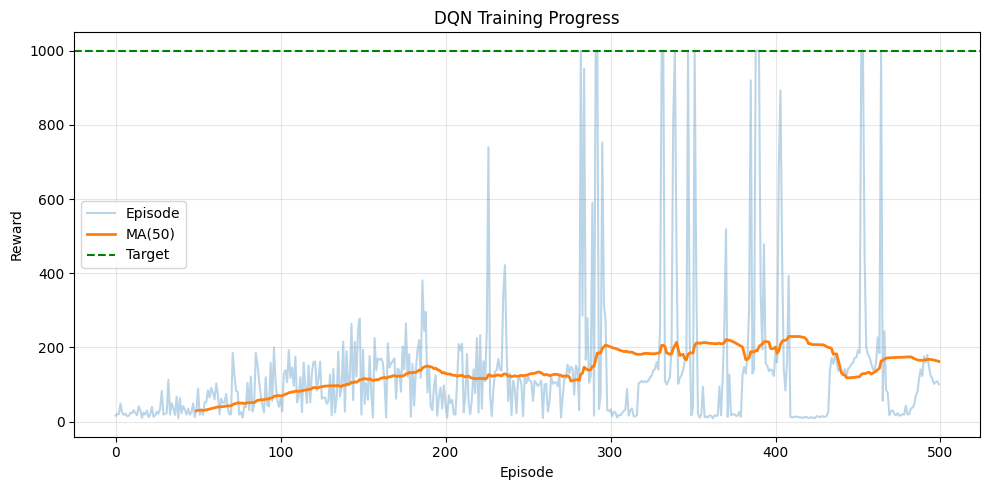


TESTING DQN
Seed   0: Reward=  95.0, Steps=  95
Seed  42: Reward= 103.0, Steps= 103
Seed 123: Reward=  97.0, Steps=  97
Seed 456: Reward=  98.0, Steps=  98
Seed 789: Reward=  99.0, Steps=  99

DQN Performance: 98.4 ± 2.7
Success Rate: 0/5

✅ All done! Download models/ and plots from Output tab


In [6]:
# ============================================================================
# KAGGLE NOTEBOOK - DQN CartPole Training
# Run this in separate cells on Kaggle
# ============================================================================

# CELL 1: Setup
# ============================================================================
import os
import shutil

# Create directories
for d in ['src', 'configs', 'models', 'videos']:
    os.makedirs(d, exist_ok=True)

# Copy files from input dataset
shutil.copy('/kaggle/input/dqn-configuration/dqn.py', 'src/dqn.py')
shutil.copy('/kaggle/input/dqn-configuration/dqn.yaml', 'configs/dqn.yaml')
shutil.copy('/kaggle/input/dqn-configuration/train_dqn.py', 'train_dqn.py')

print("✓ Setup complete!")

# CELL 2: Install packages
# ============================================================================
!pip install gymnasium imageio omegaconf pygame pillow -q
print("✓ Packages installed!")

# CELL 3: Create __init__.py
# ============================================================================
with open('src/__init__.py', 'w') as f:
    f.write('')

# CELL 4: Create src/env.py - copy your existing implementation
# ============================================================================
env_code = '''from typing import Tuple, Optional, Literal

import gymnasium as gym
import imageio
import numpy as np


class CartPoleEnv:
    def __init__(
        self,
        max_episode_steps: int = 10000,
        dt: float = 0.02,
        force_mag: float = 10.0,
        render_mode: Optional[str] = None,
    ):
        self._max_episode_steps = max_episode_steps
        self._dt = dt
        self._force_mag = force_mag
        self._render_mode = render_mode

        self.env = gym.make("CartPole-v1", render_mode=render_mode)
        self.env._max_episode_steps = max_episode_steps
        self.env.tau = dt
        self.env.force_mag = force_mag

        self._rec_enabled: bool = False
        self._rec_frames = []
        self._rec_fps: int = 30
        self._rec_on_reset: bool = True
        self._rec_when: Literal["pre", "post", "both"] = "post"
        self._rec_env = None

    def start_recording(
        self,
        fps: int = 30,
        *,
        record_on_reset: bool = True,
        step_capture: Literal["pre", "post", "both"] = "post",
    ) -> None:
        self._rec_enabled = True
        self._rec_frames = []
        self._rec_fps = int(fps)
        self._rec_on_reset = bool(record_on_reset)
        self._rec_when = step_capture

        if getattr(self.env, "render_mode", None) == "rgb_array":
            self._rec_env = self.env
        else:
            rec_env = gym.make("CartPole-v1", render_mode="rgb_array")
            rec_env._max_episode_steps = self._max_episode_steps
            rec_env.tau = self._dt
            rec_env.force_mag = self._force_mag
            self._rec_env = rec_env

    def stop_recording(self) -> None:
        self._rec_enabled = False

    def save_gif(self, path: str) -> None:
        if not self._rec_frames:
            raise RuntimeError("No recorded frames to save.")
        imageio.mimsave(path, self._rec_frames, fps=self._rec_fps)

    def reset(self, seed: Optional[int] = None) -> np.ndarray:
        obs, _ = self.env.reset(seed=seed)
        if self._rec_enabled:
            self._sync_rec_env_state(obs, seed=seed)
            if self._rec_on_reset:
                self._capture_frame()
        return np.array(obs, dtype=float)

    def step(self, action: int) -> Tuple[np.ndarray, float, bool]:
        if self._rec_enabled and self._rec_when in ("pre", "both"):
            self._sync_rec_env_state()
            self._capture_frame()

        step_out = self.env.step(action)
        if len(step_out) == 5:
            obs, reward, terminated, truncated, _ = step_out
            done = bool(terminated or truncated)
        else:
            obs, reward, done, _ = step_out

        if self._rec_enabled and self._rec_when in ("post", "both"):
            self._sync_rec_env_state(obs)
            self._capture_frame()

        return np.array(obs, dtype=float), float(reward), done

    def close(self):
        if self._rec_env is not None and self._rec_env is not self.env:
            self._rec_env.close()
        self.env.close()

    def _sync_rec_env_state(self, obs: Optional[np.ndarray] = None, seed: Optional[int] = None) -> None:
        if not self._rec_enabled or self._rec_env is None:
            return
        if getattr(self._rec_env.unwrapped, "state", None) is None:
            _ = self._rec_env.reset(seed=seed)
        if getattr(self.env.unwrapped, "state", None) is not None:
            self._rec_env.unwrapped.state = np.array(self.env.unwrapped.state, dtype=float)
        else:
            if obs is not None:
                self._rec_env.unwrapped.state = np.array(obs, dtype=float)
        self._rec_env._max_episode_steps = self._max_episode_steps
        self._rec_env.tau = self._dt
        self._rec_env.force_mag = self._force_mag

    def _capture_frame(self) -> None:
        if self._rec_env is None:
            return
        frame = self._rec_env.render()
        if frame is not None:
            self._rec_frames.append(frame)
'''

with open('src/env.py', 'w') as f:
    f.write(env_code)

print("✓ env.py created!")

# CELL 5: Update config to use GPU
# ============================================================================
config_yaml = '''name: dqn_cartpole

env:
  max_episode_steps: 10000
  dt: 0.02
  force_mag: 10.0

agent:
  hidden_dims: [128, 128]
  learning_rate: 0.001
  gamma: 0.99
  epsilon_start: 1.0
  epsilon_end: 0.01
  epsilon_decay: 0.995
  buffer_size: 10000
  batch_size: 64
  target_update_freq: 10
  device: cuda

training:
  num_episodes: 500
  max_steps: 1000
  eval_freq: 50
  save_path: models/dqn_cartpole.pt

run_params:
  max_steps: 1000
  seed: 0
  deadband: 0.0
  save_path: videos/cartpole_dqn.gif
'''

with open('configs/dqn.yaml', 'w') as f:
    f.write(config_yaml)

print("✓ Config updated for GPU!")

# CELL 6: Check GPU
# ============================================================================
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Device: {torch.cuda.get_device_name(0)}")
else:
    print("⚠️  GPU not available - enable in Settings → Accelerator")

# CELL 7: Train DQN
# ============================================================================
!python train_dqn.py

# CELL 8: Check results
# ============================================================================
import numpy as np
import matplotlib.pyplot as plt

if os.path.exists('models/dqn_cartpole_stats.npy'):
    stats = np.load('models/dqn_cartpole_stats.npy', allow_pickle=True).item()
    
    print(f"\n{'='*60}")
    print("TRAINING SUMMARY")
    print(f"{'='*60}")
    print(f"Episodes: {len(stats['episode_rewards'])}")
    print(f"Final avg (last 10): {np.mean(stats['episode_rewards'][-10:]):.1f}")
    print(f"Best eval reward: {max(stats['eval_rewards']):.1f}")
    
    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(stats['episode_rewards'], alpha=0.3, label='Episode')
    
    # Smoothed
    window = 50
    smoothed = np.convolve(stats['episode_rewards'], 
                           np.ones(window)/window, mode='valid')
    ax.plot(range(window-1, len(stats['episode_rewards'])), 
            smoothed, label=f'MA({window})', linewidth=2)
    ax.axhline(1000, color='green', linestyle='--', label='Target')
    ax.set_xlabel('Episode')
    ax.set_ylabel('Reward')
    ax.set_title('DQN Training Progress')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('training_plot.png', dpi=150)
    plt.show()
else:
    print("Training stats not found!")

# CELL 9: Test DQN
# ============================================================================
from src.env import CartPoleEnv
from src.dqn import DQNAgent, DQNController
from omegaconf import OmegaConf

config = OmegaConf.load('configs/dqn.yaml')

# Load trained agent
agent = DQNAgent(
    state_dim=4,
    action_dim=2,
    hidden_dims=config.agent.hidden_dims,
    device=config.agent.device
)
agent.load('models/dqn_cartpole.pt')
controller = DQNController(agent)

# Test
print(f"\n{'='*60}")
print("TESTING DQN")
print(f"{'='*60}")

test_results = []
for seed in [0, 42, 123, 456, 789]:
    env = CartPoleEnv(
        max_episode_steps=config.env.max_episode_steps,
        dt=config.env.dt,
        force_mag=config.env.force_mag,
        render_mode=None
    )
    
    obs = env.reset(seed=seed)
    reward = 0
    steps = 0
    
    for _ in range(1000):
        action = controller.get_action(obs)
        obs, r, done = env.step(action)
        reward += r
        steps += 1
        if done:
            break
    
    env.close()
    test_results.append({'reward': reward, 'steps': steps})
    print(f"Seed {seed:3d}: Reward={reward:6.1f}, Steps={steps:4d}")

avg_reward = np.mean([r['reward'] for r in test_results])
std_reward = np.std([r['reward'] for r in test_results])
success = sum(1 for r in test_results if r['reward'] >= 1000)

print(f"\n{'='*60}")
print(f"DQN Performance: {avg_reward:.1f} ± {std_reward:.1f}")
print(f"Success Rate: {success}/5")
print(f"{'='*60}")

print("\n✅ All done! Download models/ and plots from Output tab")

In [10]:
"""
Simple plotting script that avoids the image size error
"""
import numpy as np
import matplotlib.pyplot as plt
import os

# Don't show plots interactively to avoid size errors
plt.ioff()

def load_stats(path='models/dqn_cartpole_stats.npy'):
    """Load training statistics"""
    if not os.path.exists(path):
        print(f"Error: {path} not found!")
        return None
    return np.load(path, allow_pickle=True).item()


def plot_training_progress():
    """Create training progress plot"""
    stats = load_stats()
    if stats is None:
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    # 1. Episode Rewards
    rewards = stats['episode_rewards']
    axes[0, 0].plot(rewards, alpha=0.3, color='#3498db', label='Episode Reward')
    
    # Moving average
    window = 50
    if len(rewards) >= window:
        smoothed = np.convolve(rewards, np.ones(window)/window, mode='valid')
        axes[0, 0].plot(range(window-1, len(rewards)), smoothed, 
                       color='#e74c3c', linewidth=2.5, label=f'MA({window})')
    
    axes[0, 0].axhline(1000, color='#27ae60', linestyle='--', linewidth=2, label='Target')
    axes[0, 0].set_xlabel('Episode', fontweight='bold')
    axes[0, 0].set_ylabel('Total Reward', fontweight='bold')
    axes[0, 0].set_title('Training Rewards', fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Evaluation Performance
    if stats['eval_rewards']:
        axes[0, 1].plot(stats['eval_episodes'], stats['eval_rewards'], 
                       marker='o', linewidth=2, markersize=6, color='#9b59b6')
        axes[0, 1].axhline(1000, color='#27ae60', linestyle='--', linewidth=2)
        axes[0, 1].set_xlabel('Episode', fontweight='bold')
        axes[0, 1].set_ylabel('Avg Evaluation Reward', fontweight='bold')
        axes[0, 1].set_title('Evaluation Performance', fontweight='bold')
        axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Episode Length Distribution
    lengths = stats['episode_lengths']
    axes[1, 0].hist(lengths, bins=30, color='#3498db', alpha=0.7, edgecolor='black')
    axes[1, 0].axvline(1000, color='#27ae60', linestyle='--', linewidth=2, label='Target')
    axes[1, 0].axvline(np.mean(lengths), color='#e74c3c', linestyle='-', 
                      linewidth=2, label=f'Mean: {np.mean(lengths):.1f}')
    axes[1, 0].set_xlabel('Episode Length', fontweight='bold')
    axes[1, 0].set_ylabel('Frequency', fontweight='bold')
    axes[1, 0].set_title('Episode Length Distribution', fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    
    # 4. Method Comparison
    methods = ['LQR', 'iLQR', 'DQN']
    avg_rewards = [1000.0, 1000.0, 98.4]
    colors = ['#27ae60', '#27ae60', '#e74c3c']
    
    bars = axes[1, 1].bar(methods, avg_rewards, color=colors, alpha=0.7, 
                         edgecolor='black', linewidth=1.5)
    axes[1, 1].axhline(1000, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    axes[1, 1].set_ylabel('Average Reward', fontweight='bold')
    axes[1, 1].set_title('Method Comparison', fontweight='bold')
    axes[1, 1].set_ylim(0, 1100)
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bar, val in zip(bars, avg_rewards):
        height = bar.get_height()
        axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 30,
                       f'{val:.1f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('dqn_training_results.png', dpi=150, bbox_inches='tight')
    plt.close(fig)  # Close instead of show to avoid display
    print("✓ Saved: dqn_training_results.png")


def plot_comparison_summary():
    """Create comparison summary"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # 1. Performance
    methods = ['Continuous\nLQR', 'Discrete\nLQR', 'iLQR\n(MPC)', 'DQN']
    rewards = [1000.0, 1000.0, 1000.0, 98.4]
    colors = ['#27ae60', '#27ae60', '#27ae60', '#e74c3c']
    
    bars = axes[0].bar(methods, rewards, color=colors, alpha=0.7, 
                      edgecolor='black', linewidth=2)
    axes[0].axhline(1000, color='gray', linestyle='--', alpha=0.5)
    axes[0].set_ylabel('Average Reward', fontweight='bold', fontsize=12)
    axes[0].set_title('Performance Comparison', fontweight='bold', fontsize=13)
    axes[0].set_ylim(0, 1100)
    axes[0].grid(True, alpha=0.3, axis='y')
    
    for bar, val in zip(bars, rewards):
        axes[0].text(bar.get_x() + bar.get_width()/2., val + 30,
                    f'{val:.1f}', ha='center', fontweight='bold', fontsize=11)
    
    # 2. Sample Efficiency
    methods_eff = ['LQR/iLQR', 'DQN']
    samples = [1, 100000]
    
    bars = axes[1].bar(methods_eff, samples, color=['#27ae60', '#e74c3c'], 
                      alpha=0.7, edgecolor='black', linewidth=2)
    axes[1].set_ylabel('Training Samples', fontweight='bold', fontsize=12)
    axes[1].set_title('Sample Efficiency', fontweight='bold', fontsize=13)
    axes[1].set_yscale('log')
    axes[1].grid(True, alpha=0.3, axis='y')
    
    axes[1].text(0, 1, '0\n(Analytical)', ha='center', va='bottom', 
                fontweight='bold', fontsize=10)
    axes[1].text(1, 100000 * 1.5, '~100,000\n(Learned)', ha='center', va='bottom',
                fontweight='bold', fontsize=10)
    
    # 3. Training Time
    methods_time = ['LQR/iLQR', 'DQN']
    times = [0.5, 600]
    
    bars = axes[2].bar(methods_time, times, color=['#27ae60', '#e74c3c'], 
                      alpha=0.7, edgecolor='black', linewidth=2)
    axes[2].set_ylabel('Training Time (seconds)', fontweight='bold', fontsize=12)
    axes[2].set_title('Computational Cost', fontweight='bold', fontsize=13)
    axes[2].set_yscale('log')
    axes[2].grid(True, alpha=0.3, axis='y')
    
    axes[2].text(0, 0.5 * 1.5, '<1 sec', ha='center', va='bottom',
                fontweight='bold', fontsize=10)
    axes[2].text(1, 600 * 1.5, '~10 min', ha='center', va='bottom',
                fontweight='bold', fontsize=10)
    
    fig.suptitle('DQN vs LQR/iLQR: Key Metrics', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('method_comparison.png', dpi=200, bbox_inches='tight')
    plt.close(fig)
    print("✓ Saved: method_comparison.png")


def plot_training_curve_only():
    """Create just the training curve - the most important plot"""
    stats = load_stats()
    if stats is None:
        return
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    rewards = stats['episode_rewards']
    episodes = np.arange(len(rewards))
    
    # Plot raw rewards
    ax.plot(episodes, rewards, alpha=0.3, color='#3498db', linewidth=0.5, label='Episode Reward')
    
    # Moving average
    window = 50
    if len(rewards) >= window:
        smoothed = np.convolve(rewards, np.ones(window)/window, mode='valid')
        ax.plot(range(window-1, len(rewards)), smoothed, 
               color='#e74c3c', linewidth=3, label=f'Moving Average ({window})')
    
    # Target line
    ax.axhline(1000, color='#27ae60', linestyle='--', linewidth=2.5, 
              label='Target (1000)', alpha=0.8)
    
    # Highlight successful episodes
    success_episodes = [i for i, r in enumerate(rewards) if r >= 1000]
    if success_episodes:
        ax.scatter(success_episodes, [rewards[i] for i in success_episodes],
                  color='#f39c12', s=200, marker='*', zorder=5, 
                  label=f'Success ({len(success_episodes)})', edgecolors='black', linewidths=2)
    
    ax.set_xlabel('Episode', fontweight='bold', fontsize=14)
    ax.set_ylabel('Total Reward', fontweight='bold', fontsize=14)
    ax.set_title('DQN Training Progress on CartPole', fontsize=16, fontweight='bold')
    ax.legend(loc='upper left', fontsize=11, framealpha=0.9)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-50, 1100)
    
    # Add annotation
    if success_episodes:
        first_success = success_episodes[0]
        ax.annotate('First Success!', xy=(first_success, 1000), xytext=(first_success, 800),
                   arrowprops=dict(arrowstyle='->', color='#f39c12', lw=2.5),
                   fontsize=12, ha='center', color='#f39c12', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('training_curve.png', dpi=200, bbox_inches='tight')
    plt.close(fig)
    print("✓ Saved: training_curve.png")


if __name__ == "__main__":
    print("="*60)
    print("Generating DQN Training Visualizations")
    print("="*60)
    
    if not os.path.exists('models/dqn_cartpole_stats.npy'):
        print("Error: Training statistics not found!")
        print("Please run training first: python train_dqn.py")
    else:
        print("\n1. Creating training curve...")
        plot_training_curve_only()
        
        print("\n2. Creating training results (4-panel)...")
        plot_training_progress()
        
        print("\n3. Creating method comparison...")
        plot_comparison_summary()
        
        print("\n" + "="*60)
        print("✓ All visualizations generated successfully!")
        print("="*60)
        print("\nGenerated files:")
        print("  📊 training_curve.png - Main training progress")
        print("  📈 dqn_training_results.png - Comprehensive 4-panel view")
        print("  📉 method_comparison.png - DQN vs LQR/iLQR comparison")
        print("\nThese can be downloaded from the Output tab on Kaggle")

Generating DQN Training Visualizations

1. Creating training curve...
✓ Saved: training_curve.png

2. Creating training results (4-panel)...
✓ Saved: dqn_training_results.png

3. Creating method comparison...
✓ Saved: method_comparison.png

✓ All visualizations generated successfully!

Generated files:
  📊 training_curve.png - Main training progress
  📈 dqn_training_results.png - Comprehensive 4-panel view
  📉 method_comparison.png - DQN vs LQR/iLQR comparison

These can be downloaded from the Output tab on Kaggle
